🔑 Digite sua chave Groq API (não ficará visível): ··········
✅ Chave da Groq configurada com sucesso!

🧠 Testando prompt: zero_shot...

🧠 Testando prompt: few_shot...

🧠 Testando prompt: chain_of_thought...

✅ Resultados coletados:


,tipo,resposta
0,zero_shot,O aprendizado de máquina é uma área da intelig...
1,few_shot,O aprendizado de máquina é um campo da intelig...
2,chain_of_thought,Aqui está um passo a passo sobre o aprendizado...



📊 Métricas médias por tipo de prompt:


,clareza,relevancia,precisao
tipo,,,
chain_of_thought,9.0,9.0,8.0
few_shot,8.0,9.0,7.0
zero_shot,8.0,9.0,7.0


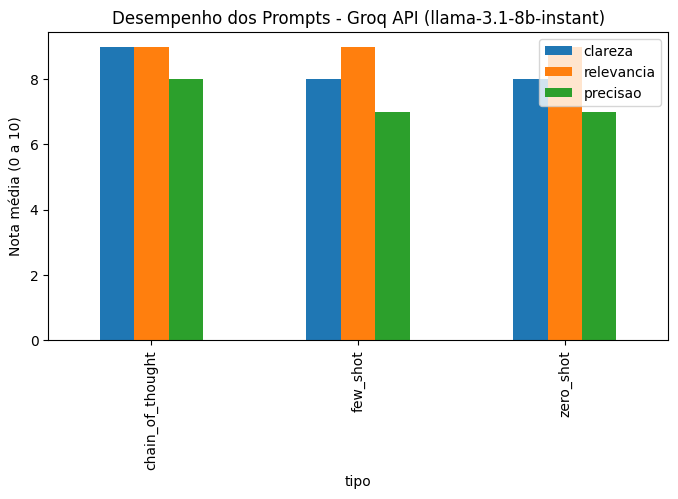


✨ Análise final concluída com sucesso!


In [17]:
# ============================================
# 🚀 Projeto: Prompt Optimizer com Groq API
# Modelo: llama-3.1-8b-instant
# ============================================

!pip install -q pandas requests matplotlib

import os
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
from getpass import getpass  # 🔐 para digitar a chave de forma segura

# ===============================
# 1. CONFIGURAÇÃO DA API GROQ
# ===============================

GROQ_API_KEY = getpass("🔑 Digite sua chave Groq API (não ficará visível): ").strip()
GROQ_API_URL = "https://api.groq.com/openai/v1/chat/completions"

if not GROQ_API_KEY:
    raise ValueError("❌ A chave da Groq API não foi fornecida.")

print("✅ Chave da Groq configurada com sucesso!")

# ===============================
# 2. FUNÇÃO PARA ENVIAR PROMPTS
# ===============================

def send_prompt_to_groq(prompt, model="llama-3.1-8b-instant", max_tokens=300, temperature=0.3):
    headers = {
        "Authorization": f"Bearer {GROQ_API_KEY}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": model,
        "messages": [
            {"role": "system", "content": "Você é um assistente útil e especializado em linguagem natural."},
            {"role": "user", "content": prompt}
        ],
        "max_tokens": max_tokens,
        "temperature": temperature
    }

    response = requests.post(GROQ_API_URL, headers=headers, json=payload)

    if response.status_code != 200:
        raise RuntimeError(
            f"Erro {response.status_code} na chamada à API:\n{response.text}"
        )

    data = response.json()
    return data["choices"][0]["message"]["content"].strip()

# ===============================
# 3. PROMPTS DE TESTE COM TOKENS PERSONALIZADOS
# ===============================

prompts = {
    "zero_shot": {
        "texto": "Explique o conceito de aprendizado de máquina em linguagem simples.",
        "max_tokens": 300
    },
    "few_shot": {
        "texto": (
            "Explique o conceito de aprendizado de máquina em linguagem simples.\n\n"
            "Exemplo: 'A IA aprende com exemplos para tomar decisões sem ser programada diretamente.'"
        ),
        "max_tokens": 350
    },
    "chain_of_thought": {
        "texto": (
            "Explique passo a passo o que é aprendizado de máquina e depois forneça um resumo simples de 1 frase no final."
        ),
        "max_tokens": 600  # ⬅ tokens maiores para chain-of-thought
    }
}

# ===============================
# 4. EXECUÇÃO DOS TESTES
# ===============================

results = []
for tipo, config in prompts.items():
    print(f"\n🧠 Testando prompt: {tipo}...")
    resposta = send_prompt_to_groq(config["texto"], max_tokens=config["max_tokens"])
    results.append({"tipo": tipo, "prompt": config["texto"], "resposta": resposta})

df = pd.DataFrame(results)
print("\n✅ Resultados coletados:")
display(df[["tipo", "resposta"]])

# ===============================
# 5. AVALIAÇÃO AUTOMÁTICA
# ===============================

def avaliar_resposta(resposta):
    avaliacao_prompt = f"""
    Avalie a seguinte resposta em uma escala de 0 a 10 para:
    - Clareza
    - Relevância
    - Precisão

    Resposta:
    {resposta}

    Retorne apenas um JSON no formato:
    {{
      "clareza": (nota),
      "relevancia": (nota),
      "precisao": (nota),
      "comentario": "breve justificativa"
    }}
    """

    try:
        avaliacao = send_prompt_to_groq(avaliacao_prompt)
        return avaliacao
    except Exception as e:
        return json.dumps({"erro": str(e)})

df["avaliacao_raw"] = df["resposta"].apply(avaliar_resposta)

# ===============================
# 6. PROCESSAR E VISUALIZAR
# ===============================

avaliacoes = []
for a in df["avaliacao_raw"]:
    try:
        aval = json.loads(a)
        avaliacoes.append(aval)
    except:
        avaliacoes.append({"clareza": None, "relevancia": None, "precisao": None, "comentario": "Erro no parse"})

avaliacoes_df = pd.DataFrame(avaliacoes)
final_df = pd.concat([df, avaliacoes_df], axis=1)

metricas = final_df[["tipo", "clareza", "relevancia", "precisao"]].groupby("tipo").mean()
print("\n📊 Métricas médias por tipo de prompt:")
display(metricas)

metricas.plot(kind="bar", figsize=(8,4), title="Desempenho dos Prompts - Groq API (llama-3.1-8b-instant)")
plt.ylabel("Nota média (0 a 10)")
plt.show()

print("\n✨ Análise final concluída com sucesso!")
